In [42]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import json
import requests
import pandas as pd
import numpy as np
import tqdm
import timeit
import warnings
import csv

In [43]:
df = pd.read_csv('./covid19.csv', header=None)

x = df[0].to_numpy()
y = df[1].to_numpy()

X =  x.reshape(len(y), 1)
y =  y.reshape(len(y), 1)

include_bias = False

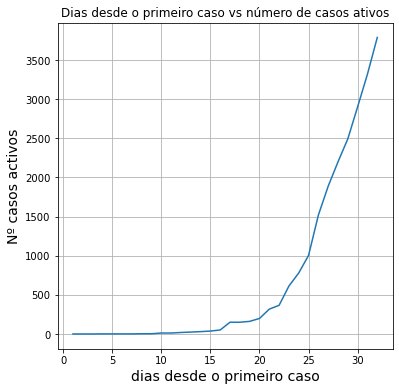

In [44]:
# Plot original data versus noisy version.
fig = plt.figure(figsize=(6,6))
plt.xlabel('dias desde o primeiro caso', fontsize=14)
plt.ylabel('Nº casos activos', fontsize=14)
plt.plot(x, y)
plt.grid()
plt.title('Dias desde o primeiro caso vs número de casos ativos')
#Show the plot.
plt.show()

## Holdout cross-validation (80/20%)

In [45]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Split the whole set into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print('Size of Training Set:', len(y_train))
print('Size of Validation Set:', len(y_val))

error_train = []
error_val = []
mean_vec = []
std_vec = []
for d in range(1, 13):
    
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    
    # Perform polynomial regression.
    polynomial_regression.fit(x_train, y_train)
    
    y_train_predict = polynomial_regression.predict(x_train)
    
    y_val_predict = polynomial_regression.predict(x_val)    
    
    error_train.append(np.sqrt(mean_squared_error(y_train, y_train_predict)))

    error_val.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))

print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))   

Size of Training Set: 25
Size of Validation Set: 7
Tempo de execução: 0.0231 [s]


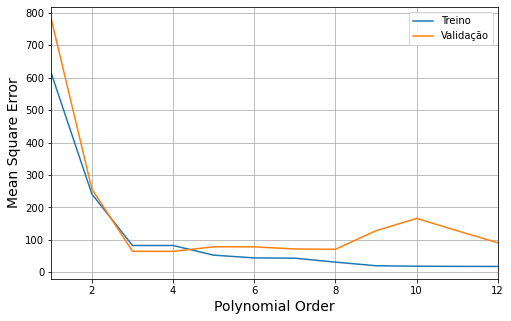

In [48]:
# Plot results.
plt.figure(figsize=(8, 5))
plt.plot(range(1, 13), error_train, label='Treino')
plt.plot(range(1, 13), error_val, label='Validação')
plt.xlabel('Polynomial Order',  fontsize=14)
plt.ylabel('Mean Square Error',  fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()
#Show the plot.
plt.show()

## K-fold cross validation (k=10)

In [23]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the k-Fold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

error_train = []
error_val = []
mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, X, y, scoring='neg_mean_squared_error', cv=kfold)
    
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())

print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))  

Tempo de execução: 0.2688 [s]


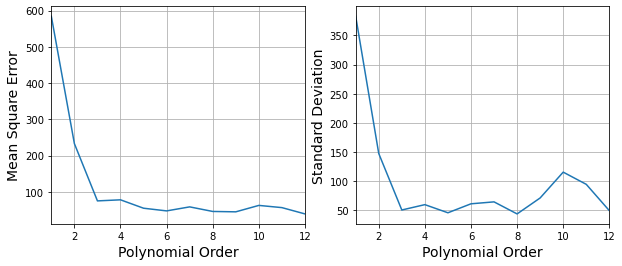

In [30]:
# Plot results.
plt.figure(figsize=(10, 4))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Polynomial Order',  fontsize=14)
plt.ylabel('Mean Square Error',  fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Polynomial Order',  fontsize=14)
plt.ylabel('Standard Deviation',  fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

#Show the plot.
plt.show()

   ## Leave-p-out cross-validation (p=1)

In [28]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LPOCV object.
lpocv = LeavePOut(p=1)

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, X, y, scoring='neg_mean_squared_error', cv=lpocv)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))


Tempo de execução: 0.6555 [s]


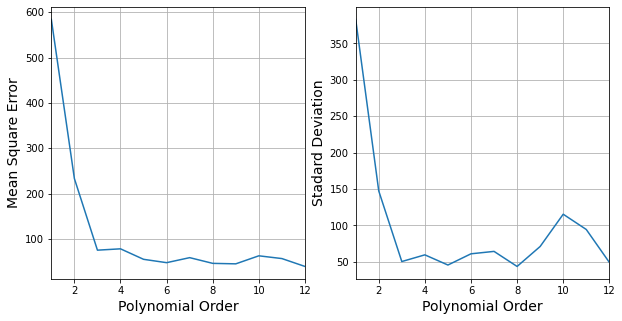

In [32]:
# Plot results.
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Polynomial Order', fontsize=14)
plt.ylabel('Mean Square Error', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Polynomial Order', fontsize=14)
plt.ylabel('Stadard Deviation', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()

#Show the plot.
plt.show()

## Learning-curves

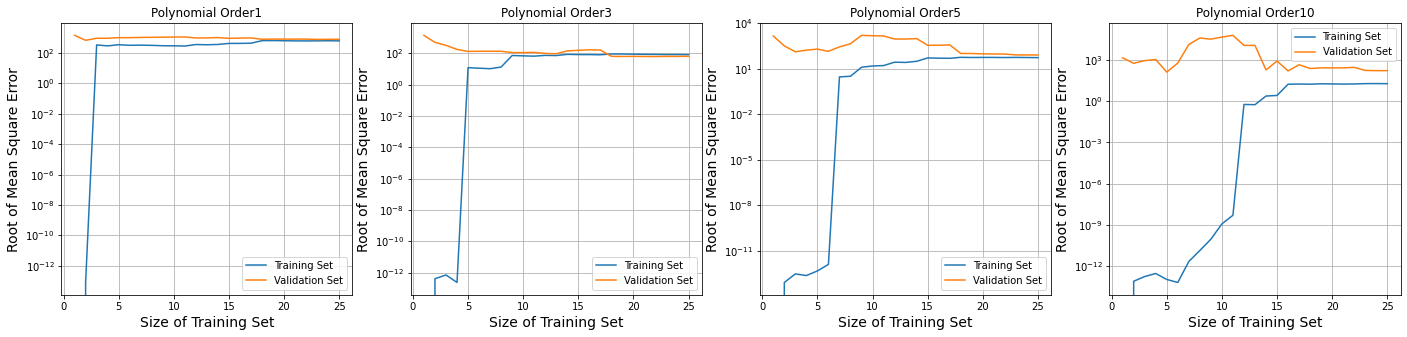

In [33]:
degrees = [1, 3, 5, 10]

plt.figure(figsize=(24, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    error_training = []
    error_validation = []
    error_test = []
    for m in range(1,len(x_train)+1):

        # Perform polynomial regression.
        polynomial_regression.fit(x_train[:m], y_train[:m])

        # Use the trained model for prediction of the training set.
        y_train_predict = polynomial_regression.predict(x_train[:m])

        # Use the trained model for prediction of the validation set.
        y_val_predict = polynomial_regression.predict(x_val)       

        # Calculate MSE for training set.
        error_training.append(mean_squared_error(y_train[:m], y_train_predict))

        # Calculate MSE for validation set.
        error_validation.append(mean_squared_error(y_val, y_val_predict))     

    plt.plot(range(1,len(x_train)+1), np.sqrt(error_training), label='Training Set')
    plt.plot(range(1,len(x_train)+1), np.sqrt(error_validation), label='Validation Set')
    plt.yscale('log')
    plt.xlabel('Size of Training Set', fontsize=14)
    plt.ylabel('Root of Mean Square Error', fontsize=14)
    plt.grid()
    plt.title('Polynomial Order'+str(degrees[i]))
    plt.legend(loc='best')
    
#Show the plot.
plt.show()

## Model training

In [34]:
# Best polynomial order
degree = 3

include_bias = False

# Instantiate a polynomial with the given degree.
poly_features = PolynomialFeatures(degree=degree, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
std_scaler = StandardScaler()
# Instantiate a linear regressor.
lin_reg = LinearRegression()

# Create a pipeline of actions.
model = Pipeline([
    ("poly_features", poly_features),
    ("std_scaler", std_scaler),
    ("lin_reg", lin_reg),
])

# Train model.
model.fit(X, y)

# Perform prediction for 70 days.
X_pred = np.arange(1, 70).reshape(-1, 1)
y_pred = model.predict(X_pred)
X_pred = X_pred.reshape(1, -1)[0]

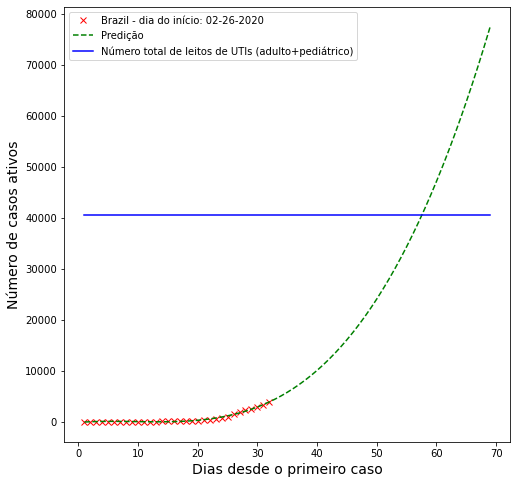

In [37]:
plt.figure(figsize=(8, 8))
plt.plot(X,y,'rx',label='Brazil - dia do início: 02-26-2020')
plt.plot(X_pred,y_pred,'g--',label='Predição')
plt.plot(X_pred,40600*np.ones(len(X_pred)),'b',label='Número total de leitos de UTIs (adulto+pediátrico)')
plt.xlabel('Dias desde o primeiro caso', fontsize=14)
plt.ylabel('Número de casos ativos', fontsize=14)
plt.legend()
plt.show()

In [38]:
colapso_de_leitos_UTI = min([i+1 for i,v in enumerate(y_pred) if v >= 40600])
print('Collapse of ICU beds: ', colapso_de_leitos_UTI)

Collapse of ICU beds:  58
